In [1]:
import shutup
shutup.please()

import pandas as pd
import numpy as np
from datetime import datetime
import os, os.path, pickle, sys
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

sys.path.append("/Users/hn/Documents/00_GitHub/Rangeland/Python_Codes/")
import rangeland_core as rc

### Directories

In [2]:
data_dir_base = "/Users/hn/Documents/01_research_data/RangeLand/Data/"
census_population_dir = data_dir_base + "census/"
# Shannon_data_dir = data_dir_base + "Shannon_Data/"
# USDA_data_dir = data_dir_base + "/NASS_downloads/"
param_dir = data_dir_base + "parameters/"
Min_data_base = data_dir_base + "Min_Data/"
reOrganized_dir = data_dir_base + "reOrganized/"

plots_dir = data_dir_base + "plots/"

In [3]:
SoI = ["Alabama", "Arkansas", "California", 
       "Colorado", "Florida", "Georgia", 
       "Idaho", "Illinois", "Iowa", 
       "Kansas", "Kentucky", "Louisiana", 
       "Mississippi", "Missouri", "Montana", 
       "Nebraska", "New Mexico", "North Dakota", 
       "Oklahoma", "Oregon", "South Dakota", 
       "Tennessee", "Texas", "Virginia", 
       "Wyoming"]

abb_dict = pd.read_pickle(param_dir + "state_abbreviations.sav")
SoI_abb = []
for x in SoI:
    SoI_abb = SoI_abb + [abb_dict["full_2_abb"][x]]

In [4]:
d = {'state' : abb_dict["abb_2_full"].keys(),
     'full_state' : abb_dict["abb_2_full"].values()}
 
# creating a Dataframe object 
state_abbrFull_df = pd.DataFrame(d)
state_abbrFull_df = state_abbrFull_df[state_abbrFull_df.full_state.isin(SoI)]
state_abbrFull_df.reset_index(drop=True, inplace=True)
state_abbrFull_df.head(2)

,state,full_state
0,AL,Alabama
1,AR,Arkansas


#### List of county names and FIPs

In [5]:
county_id_name_fips = pd.read_csv(Min_data_base + "county_id_name_fips.csv")
county_id_name_fips.rename(columns=lambda x: x.lower().replace(" ", "_"), inplace=True)

county_id_name_fips.sort_values(by=["state", "county"], inplace=True)
county_id_name_fips.rename(columns={"county": "county_fips"}, inplace=True)

county_id_name_fips = rc.correct_Mins_FIPS(df=county_id_name_fips, col_="county_fips")
county_id_name_fips.reset_index(drop=True, inplace=True)
county_id_name_fips.head(2)

,county_fips,county_name,fips,state
0,02013,Aleutians East Borough,2013,AK
1,02016,Aleutians West Census Area,2016,AK


In [6]:
USDA_data = pd.read_pickle(reOrganized_dir + "USDA_data.sav")
print ("-----------  reading USDA data  -----------")
cattle_inventory = USDA_data["cattle_inventory"]
#
# pick only 25 states we want
#
print ("----------- subset to 25 states -----------")
cattle_inventory = cattle_inventory[cattle_inventory.state.isin(SoI)].copy()
cattle_inventory.sort_values(by=["year", "county_fips"], inplace=True)
print ()

print (f"{cattle_inventory.data_item.unique() = }")
print (f"{cattle_inventory.commodity.unique() = }")
print ()
print (f"{len(cattle_inventory.state.unique()) = }")

census_years = sorted(list(cattle_inventory.year.unique()))
print (f"{census_years = }")

# pick only useful columns
inv_col_ = "cattle_cow_beef_inventory"
cattle_inventory = cattle_inventory[["year", "county_fips", inv_col_]]

print (f"{len(cattle_inventory.county_fips.unique()) = }")
cattle_inventory.head(2)

-----------  reading USDA data  -----------
----------- subset to 25 states -----------

cattle_inventory.data_item.unique() = array(['CATTLE, COWS, BEEF - INVENTORY'], dtype=object)
cattle_inventory.commodity.unique() = array(['CATTLE'], dtype=object)

len(cattle_inventory.state.unique()) = 25
census_years = [1997, 2002, 2007, 2012, 2017]
len(cattle_inventory.county_fips.unique()) = 2052


,year,county_fips,cattle_cow_beef_inventory
6180,1997,01001,8300.0
6190,1997,01003,14956.0


## Read ```NPP``` and ```SW```

**Min has an extra "1" as leading digit in FIPS!!**

In [7]:
NPP = pd.read_csv(Min_data_base + "county_annual_MODIS_NPP.csv")
NPP.rename(columns={"NPP": "modis_npp"}, inplace=True)

NPP = rc.correct_Mins_FIPS(df=NPP, col_="county")
NPP.rename(columns={"county": "county_fips"}, inplace=True)

print (f"{NPP.year.min() = }")
NPP.head(2)

NPP.year.min() = 2001


,year,county_fips,modis_npp
0,2001,01003,0.926441
1,2001,01005,0.629133


In [8]:
filename = reOrganized_dir + "county_seasonal_temp_ppt_weighted.sav"
seasonal_weather = pd.read_pickle(filename)
print (f"{seasonal_weather.keys() = }")
seasonal_weather = seasonal_weather["seasonal"]
seasonal_weather.head(2)

seasonal_weather.keys() = dict_keys(['seasonal', 'source_code', 'Author', 'Min_file_used', 'Date'])


,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg
0,01003,1979,656.015,678.306,388.477,252.774,11.042778,24.376025,26.330803,15.175087
1,01005,1979,494.41,470.324,277.067,203.357,9.200633,22.690754,24.926689,13.078413


In [9]:
seasonal_var_cols = seasonal_weather.columns[2:10]
for a_col in seasonal_var_cols:
    seasonal_weather[a_col] = seasonal_weather[a_col].astype(float)

In [10]:
# pick only census years
NPP = NPP[NPP.year.isin(census_years)]
NPP.reset_index(drop=True, inplace=True)
NPP.head(2)

# pick only census years
seasonal_weather = seasonal_weather[seasonal_weather.year.isin(census_years)]
seasonal_weather.reset_index(drop=True, inplace=True)
seasonal_weather.head(2)

,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg
0,01003,1997,406.441,949.277,143.882,422.485,14.095789,23.213754,26.850115,14.651630
1,01005,1997,374.950,497.590,119.335,537.954,12.495322,21.541057,24.961213,12.270674


In [11]:
print (f"{len(NPP.county_fips.unique()) = }")
print (f"{len(seasonal_weather.county_fips.unique()) = }")

print (f"{NPP.shape = }")
print (f"{len(NPP.county_fips.unique()) = }")
NPP = NPP[NPP.county_fips.isin(list(county_id_name_fips.county_fips.unique()))].copy()
print (f"{NPP.shape = }")
print (f"{len(NPP.county_fips.unique()) = }")
NPP.head(2)

len(NPP.county_fips.unique()) = 2256
len(seasonal_weather.county_fips.unique()) = 1648
NPP.shape = (9024, 3)
len(NPP.county_fips.unique()) = 2256
NPP.shape = (8992, 3)
len(NPP.county_fips.unique()) = 2248


,year,county_fips,modis_npp
0,2002,01003,0.826076
1,2002,01005,0.484333


In [12]:
print (f"{seasonal_weather.shape = }")
print (f"{len(seasonal_weather.county_fips.unique()) = }")
LL = list(county_id_name_fips.county_fips.unique())
seasonal_weather = seasonal_weather[seasonal_weather.county_fips.isin(LL)].copy()
print (f"{len(seasonal_weather.county_fips.unique()) = }")
print (f"{seasonal_weather.shape = }")

seasonal_weather.shape = (8240, 10)
len(seasonal_weather.county_fips.unique()) = 1648
len(seasonal_weather.county_fips.unique()) = 1647
seasonal_weather.shape = (8235, 10)


In [13]:
county_id_name_fips.head(2)

,county_fips,county_name,fips,state
0,02013,Aleutians East Borough,2013,AK
1,02016,Aleutians West Census Area,2016,AK


In [14]:
print (f"{(NPP.year.unique()) = }")
print (f"{len(NPP.county_fips.unique()) = }")
print (f"{len(cattle_inventory.county_fips.unique()) = }")

(NPP.year.unique()) = array([2002, 2007, 2012, 2017])
len(NPP.county_fips.unique()) = 2248
len(cattle_inventory.county_fips.unique()) = 2052


In [15]:
for a_year in NPP.year.unique():
    df = NPP[NPP.year == a_year]
    print (f"{len(df.county_fips.unique()) = }")
    
NPP.head(2)

len(df.county_fips.unique()) = 2248
len(df.county_fips.unique()) = 2248
len(df.county_fips.unique()) = 2248
len(df.county_fips.unique()) = 2248


,year,county_fips,modis_npp
0,2002,01003,0.826076
1,2002,01005,0.484333


### Rangeland area

In [16]:
# Rangeland area and Total area:
county_RA_and_TA_fraction = pd.read_csv(reOrganized_dir + "county_rangeland_and_totalarea_fraction.csv")
county_RA_and_TA_fraction.rename(columns={"fips_id": "county_fips"}, inplace=True)

county_RA_and_TA_fraction = rc.correct_Mins_FIPS(df=county_RA_and_TA_fraction, col_="county_fips")
L = len(county_RA_and_TA_fraction.county_fips.unique())
print ("number of counties in county_RA_and_TA_fraction are {}.".format(L))
print (county_RA_and_TA_fraction.shape)
county_RA_and_TA_fraction.head(2)

number of counties in county_RA_and_TA_fraction are 2379.
(2379, 4)


,county_fips,rangeland_acre,county_area_acre,rangeland_fraction
0,01003,13037.43,1060302.72,0.010000
1,01005,18.23,575781.12,0.000032


In [17]:
county_annual_NPP_Ra = pd.merge(NPP, county_RA_and_TA_fraction, on = ["county_fips"], how = "left")
county_annual_NPP_Ra.head(2)

,year,county_fips,modis_npp,rangeland_acre,county_area_acre,rangeland_fraction
0,2002,01003,0.826076,13037.43,1060302.72,0.010000
1,2002,01005,0.484333,18.23,575781.12,0.000032


In [18]:
county_annual_NPP_Ra = rc.covert_unitNPP_2_toal(NPP_df=county_annual_NPP_Ra, 
                                                npp_col_= "modis_npp", 
                                                area_col_= "rangeland_acre",
                                                new_col_ = "county_rangeland_npp")
### Security check to not make mistake later:
county_annual_NPP_Ra.drop(columns=['modis_npp'], inplace=True)
county_annual_NPP_Ra.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp
0,2002,01003,13037.43,1060302.72,0.010000,4.358434e+07
1,2002,01005,18.23,575781.12,0.000032,3.573136e+04


In [19]:
county_annual_SW_Ra = pd.merge(seasonal_weather, county_RA_and_TA_fraction, on=["county_fips"], how="left")
county_annual_SW_Ra.head(2)

,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,rangeland_acre,county_area_acre,rangeland_fraction
0,01003,1997,406.441,949.277,143.882,422.485,14.095789,23.213754,26.850115,14.651630,13037.43,1060302.72,0.010000
1,01005,1997,374.950,497.590,119.335,537.954,12.495322,21.541057,24.961213,12.270674,18.23,575781.12,0.000032


In [20]:
print (f"{sorted(cattle_inventory.year.unique())     = }")
print (f"{sorted(county_annual_NPP_Ra.year.unique()) = }")
print (f"{sorted(county_annual_SW_Ra.year.unique()) = }")

sorted(cattle_inventory.year.unique())     = [1997, 2002, 2007, 2012, 2017]
sorted(county_annual_NPP_Ra.year.unique()) = [2002, 2007, 2012, 2017]
sorted(county_annual_SW_Ra.year.unique()) = [1997, 2002, 2007, 2012, 2017]


In [21]:
common_years = set(cattle_inventory.year.unique()).\
  intersection(set(county_annual_NPP_Ra.year.unique())).\
  intersection(set(county_annual_SW_Ra.year.unique()))
common_years

{2002, 2007, 2012, 2017}

In [22]:
cattle_inventory = cattle_inventory[cattle_inventory.year.isin(list(common_years))]
county_annual_SW_Ra = county_annual_SW_Ra[county_annual_SW_Ra.year.isin(common_years)]

In [23]:
print (len(cattle_inventory.county_fips.unique()))
print (len(county_annual_NPP_Ra.county_fips.unique()))
print (len(county_annual_SW_Ra.county_fips.unique()))

2000
2248
1647


## NPP has a lot of missing counties

 - Min says he had a threshld about rangeland/pasture.
 - subset the ```NPP``` and ```Cattle``` to the intersection of counties present.
 - It seems there are different number of counties in each year in cattle inventory. Find intersection of those as well.

In [24]:
all_cattle_counties = set(cattle_inventory.county_fips.unique())
print (f"{len(all_cattle_counties) = }")

for a_year in sorted(cattle_inventory.year.unique()):
    curr_cow = cattle_inventory[cattle_inventory.year == a_year].copy()
    curr_cow_counties = set(curr_cow.county_fips.unique())
    all_cattle_counties = all_cattle_counties.intersection(curr_cow_counties)
    print (a_year)
    print (f"{len(all_cattle_counties) = }")
    print("====================================================================")

len(all_cattle_counties) = 2000
2002
len(all_cattle_counties) = 1627
2007
len(all_cattle_counties) = 1298
2012
len(all_cattle_counties) = 1075
2017
len(all_cattle_counties) = 910


In [25]:
all_county_annual_NPP_Ra = set(county_annual_NPP_Ra.county_fips.unique())
print (f"{len(all_county_annual_NPP_Ra) = }")

for a_year in sorted(county_annual_NPP_Ra.year.unique()):
    curr = county_annual_NPP_Ra[county_annual_NPP_Ra.year == a_year].copy()
    curr_counties = set(curr.county_fips.unique())
    all_county_annual_NPP_Ra = all_county_annual_NPP_Ra.intersection(curr_counties)
    print (a_year)
    print (f"{len(all_county_annual_NPP_Ra) = }")
    print("====================================================================")

len(all_county_annual_NPP_Ra) = 2248
2002
len(all_county_annual_NPP_Ra) = 2248
2007
len(all_county_annual_NPP_Ra) = 2248
2012
len(all_county_annual_NPP_Ra) = 2248
2017
len(all_county_annual_NPP_Ra) = 2248


In [26]:
all_county_annual_SW_Ra = set(county_annual_SW_Ra.county_fips.unique())
print (f"{len(all_county_annual_SW_Ra) = }")

for a_year in sorted(county_annual_SW_Ra.year.unique()):
    curr = county_annual_SW_Ra[county_annual_SW_Ra.year == a_year].copy()
    curr_counties = set(curr.county_fips.unique())
    all_county_annual_SW_Ra = all_county_annual_SW_Ra.intersection(curr_counties)
    print (a_year)
    print (f"{len(all_county_annual_SW_Ra) = }")
    print("====================================================================")

len(all_county_annual_SW_Ra) = 1647
2002
len(all_county_annual_SW_Ra) = 1647
2007
len(all_county_annual_SW_Ra) = 1647
2012
len(all_county_annual_SW_Ra) = 1647
2017
len(all_county_annual_SW_Ra) = 1647


In [27]:
# choose only the counties that are present in all years:
cattle_inventory = cattle_inventory[cattle_inventory.county_fips.isin(list(all_cattle_counties))]

In [28]:
SW_counties = set(county_annual_SW_Ra.county_fips.unique())
NPP_counties = set(county_annual_NPP_Ra.county_fips.unique())
cow_counties = set(cattle_inventory.county_fips.unique())

county_intersection = NPP_counties.intersection(cow_counties)
county_intersection = county_intersection.intersection(SW_counties)

In [29]:
county_annual_SW_Ra = county_annual_SW_Ra[county_annual_SW_Ra.county_fips.isin(list(county_intersection))]
county_annual_NPP_Ra = county_annual_NPP_Ra[county_annual_NPP_Ra.county_fips.isin(list(county_intersection))]
cattle_inventory = cattle_inventory[cattle_inventory.county_fips.isin(list(county_intersection))]

print (f"{county_annual_SW_Ra.shape = }")
print (f"{county_annual_NPP_Ra.shape = }")
print (f"{cattle_inventory.shape     = }")
print ()
print (f"{len(county_annual_SW_Ra.county_fips.unique())  = }")
print (f"{len(county_annual_NPP_Ra.county_fips.unique()) = }")
print (f"{len(cattle_inventory.county_fips.unique())     = }")
print ()
print (f"{sorted(county_annual_SW_Ra.year.unique())  = }")
print (f"{sorted(county_annual_NPP_Ra.year.unique()) = }")
print (f"{sorted(cattle_inventory.year.unique())     = }")

county_annual_SW_Ra.shape = (2780, 13)
county_annual_NPP_Ra.shape = (2780, 6)
cattle_inventory.shape     = (2780, 3)

len(county_annual_SW_Ra.county_fips.unique())  = 695
len(county_annual_NPP_Ra.county_fips.unique()) = 695
len(cattle_inventory.county_fips.unique())     = 695

sorted(county_annual_SW_Ra.year.unique())  = [2002, 2007, 2012, 2017]
sorted(county_annual_NPP_Ra.year.unique()) = [2002, 2007, 2012, 2017]
sorted(cattle_inventory.year.unique())     = [2002, 2007, 2012, 2017]


In [30]:
county_annual_NPP_Ra_cattleInv = pd.merge(county_annual_NPP_Ra, cattle_inventory, 
                                          on=["county_fips", "year"],
                                          how="left")

print (f"{cattle_inventory.shape = }")
print (f"{county_annual_NPP_Ra.shape = }")
print (f"{county_annual_NPP_Ra_cattleInv.shape = }")
county_annual_NPP_Ra_cattleInv.head(2)

cattle_inventory.shape = (2780, 3)
county_annual_NPP_Ra.shape = (2780, 6)
county_annual_NPP_Ra_cattleInv.shape = (2780, 7)


,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory
0,2002,01055,57.60,352368.00,0.000163,130631.174115,12020.0
1,2002,01129,95.62,697429.12,0.000137,206902.523895,5364.0


In [31]:
county_annual_SW_Ra_cattleInv = pd.merge(county_annual_SW_Ra, cattle_inventory,
                                         on=["county_fips", "year"], how="left")

print (f"{cattle_inventory.shape = }")
print (f"{county_annual_SW_Ra.shape = }")
print (f"{county_annual_SW_Ra_cattleInv.shape = }")
county_annual_SW_Ra_cattleInv.head(2)

cattle_inventory.shape = (2780, 3)
county_annual_SW_Ra.shape = (2780, 13)
county_annual_SW_Ra_cattleInv.shape = (2780, 14)


,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory
0,01055,2002,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,57.60,352368.00,0.000163,12020.0
1,01129,2002,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,95.62,697429.12,0.000137,5364.0


In [32]:
county_annual_NPP_Ra_cattleInv.sort_values(by=["year", "county_fips"], inplace=True)
county_annual_NPP_Ra_cattleInv.reset_index(drop=True, inplace=True)
county_annual_NPP_Ra_cattleInv.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory
0,2002,01055,57.60,352368.00,0.000163,130631.174115,12020.0
1,2002,01129,95.62,697429.12,0.000137,206902.523895,5364.0


In [33]:
county_annual_SW_Ra_cattleInv.sort_values(by=["year", "county_fips"], inplace=True)
county_annual_SW_Ra_cattleInv.reset_index(drop=True, inplace=True)
county_annual_SW_Ra_cattleInv.head(2)

,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory
0,01055,2002,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,57.60,352368.00,0.000163,12020.0
1,01129,2002,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,95.62,697429.12,0.000137,5364.0


## County-level Change

In [34]:
perc_change_col_ = "cow_beef_inv_change%"

In [35]:
columns_ = ["county_fips", "window", "cow_beef_inv_change", perc_change_col_]
num_rows = len(cattle_inventory.county_fips.unique()) * (len(cattle_inventory.year.unique()) - 1)

inv_change_cnty_yr2yr = pd.DataFrame(index=range(num_rows), columns=columns_)

print (f"{inv_change_cnty_yr2yr.shape = }")

inv_change_cnty_yr2yr["county_fips"] = inv_change_cnty_yr2yr["county_fips"].astype(str)
inv_change_cnty_yr2yr["window"] = inv_change_cnty_yr2yr["window"].astype(str)
inv_change_cnty_yr2yr[perc_change_col_] = inv_change_cnty_yr2yr[perc_change_col_].astype(float)
inv_change_cnty_yr2yr[perc_change_col_] = inv_change_cnty_yr2yr[perc_change_col_].astype(float)

inv_change_cnty_yr2yr.head(2)

inv_change_cnty_yr2yr.shape = (2085, 4)


,county_fips,window,cow_beef_inv_change,cow_beef_inv_change%
0,nan,nan,NaN,NaN
1,nan,nan,NaN,NaN


In [36]:
pointer = 0

for a_cnty in cattle_inventory.county_fips.unique():
    curr_df = county_annual_NPP_Ra_cattleInv[county_annual_NPP_Ra_cattleInv.county_fips == a_cnty]
    inv_change = curr_df.iloc[1:]["cattle_cow_beef_inventory"].values - \
                 curr_df.iloc[:-1]["cattle_cow_beef_inventory"].values
    
    inv_change_perc = (inv_change*100/curr_df.iloc[:-1]["cattle_cow_beef_inventory"].values).round(2)

    L = [x+"-" for x in list(curr_df.iloc[:-1]["year"].astype(str))]
    window_ = [i + j for i, j in zip(L, list(curr_df.iloc[1:]["year"].astype(str)) )]
    
    inv_change_cnty_yr2yr.loc[pointer:pointer+len(inv_change)-1, "county_fips"] = a_cnty
    inv_change_cnty_yr2yr.loc[pointer:pointer+len(inv_change)-1, "window"] = window_
    inv_change_cnty_yr2yr.loc[pointer:pointer+len(inv_change)-1, "cow_beef_inv_change"] = inv_change
    inv_change_cnty_yr2yr.loc[pointer:pointer+len(inv_change)-1, perc_change_col_] = inv_change_perc
    
    pointer += len(inv_change)
    del(a_cnty, window_, inv_change, inv_change_perc)

inv_change_cnty_yr2yr = pd.merge(inv_change_cnty_yr2yr, 
                                 county_id_name_fips[["county_fips", "state", "county_name"]], 
                                 on = ["county_fips"], how = "left")

In [37]:
inv_change_cnty_yr2yr.head(4)

,county_fips,window,cow_beef_inv_change,cow_beef_inv_change%,state,county_name
0,01055,2002-2007,-2585.0,-21.51,AL,Etowah County
1,01055,2007-2012,1212.0,12.85,AL,Etowah County
2,01055,2012-2017,-1775.0,-16.67,AL,Etowah County
3,01129,2002-2007,213.0,3.97,AL,Washington County


### Change in all counties and all years

In [38]:
print (("\033[1m" + "In all counties over all years:" + "\033[0m"))
print ()

s_idx = inv_change_cnty_yr2yr[perc_change_col_].idxmin()
s_ = inv_change_cnty_yr2yr.loc[s_idx, perc_change_col_]
st_cnty = inv_change_cnty_yr2yr.loc[s_idx, "county_name"] + ", " + inv_change_cnty_yr2yr.loc[s_idx, "state"]
print ("Minimum change is [{}%]: {}.".format(s_, st_cnty))
del(s_, s_idx, st_cnty)

s_idx = inv_change_cnty_yr2yr[perc_change_col_].idxmax()
s_ = inv_change_cnty_yr2yr.loc[s_idx, perc_change_col_]
st_cnty = inv_change_cnty_yr2yr.loc[s_idx, "county_name"] + ", " + inv_change_cnty_yr2yr.loc[s_idx, "state"]
print ("Maximum change is [{}%]: {}.".format(s_, st_cnty))
del(s_, s_idx, st_cnty)

s_ = inv_change_cnty_yr2yr[perc_change_col_].mean().round(2)
print ("Average change is [{}%].".format(s_))
del(s_)

s_ = (np.float64(inv_change_cnty_yr2yr[perc_change_col_].std())).round(2)
print ("SD.  of change is [{}%].".format(s_))
del(s_)

In all counties over all years:

Minimum change is [-81.47%]: Saint Louis County, MO.
Maximum change is [372.7%]: Assumption Parish, LA.
Average change is [1.35%].
SD.  of change is [29.42%].


In [39]:
print (("\033[1m" + "In all counties over all years (absolute values):" + "\033[0m"))
print ()

s_idx = np.abs(inv_change_cnty_yr2yr[perc_change_col_]).idxmin()
s_ = inv_change_cnty_yr2yr.loc[s_idx, perc_change_col_]
st_cnty = inv_change_cnty_yr2yr.loc[s_idx, "county_name"] + ", " + inv_change_cnty_yr2yr.loc[s_idx, "state"]
print ("Minimum change is [{}%]: {}.".format(s_, st_cnty))
del(s_, s_idx, st_cnty)

s_idx = np.abs(inv_change_cnty_yr2yr[perc_change_col_]).idxmax()
s_ = inv_change_cnty_yr2yr.loc[s_idx, perc_change_col_]
st_cnty = inv_change_cnty_yr2yr.loc[s_idx, "county_name"] + ", " + inv_change_cnty_yr2yr.loc[s_idx, "state"]
print ("Maximum change is [{}%]: {}.".format(s_, st_cnty))
del(s_, s_idx, st_cnty)

s_ = np.abs(inv_change_cnty_yr2yr[perc_change_col_]).mean().round(2)
print ("Average change is [{}%].".format(s_))
del(s_)

In all counties over all years (absolute values):

Minimum change is [-0.02%]: Phillips County, MT.
Maximum change is [372.7%]: Assumption Parish, LA.
Average change is [19.87%].


In [40]:
for a_window in inv_change_cnty_yr2yr.window.unique():
    df_ = inv_change_cnty_yr2yr[inv_change_cnty_yr2yr.window == a_window]
    print (("\033[1m" + "In all counties in " + a_window + "\033[0m"))
    print ()
    
    s_idx = df_[perc_change_col_].idxmin()
    s_ = df_.loc[s_idx, perc_change_col_]
    st_cnty = df_.loc[s_idx, "county_name"] + ", " + df_.loc[s_idx, "state"]
    print ("Minimum change is [{}%]: {}.".format(s_, st_cnty))
    del(s_, s_idx, st_cnty)

    s_idx = df_[perc_change_col_].idxmax()
    s_ = df_.loc[s_idx, perc_change_col_]
    st_cnty = df_.loc[s_idx, "county_name"] + ", " + df_.loc[s_idx, "state"]
    print ("Maximum change is [{}%]: {}.".format(s_, st_cnty))
    del(s_, s_idx, st_cnty)

    s_ = df_[perc_change_col_].mean().round(2)
    print ("Average change is [{}%]".format(s_))
    del(s_)

    s_ = np.float64(df_[perc_change_col_].std()).round(2)
    print ("SD.  of change is [{}]".format(s_))
    del(s_)
    print ("=================================")

In all counties in 2002-2007

Minimum change is [-68.09%]: Shoshone County, ID.
Maximum change is [372.7%]: Assumption Parish, LA.
Average change is [2.35%]
SD.  of change is [28.01]
In all counties in 2007-2012

Minimum change is [-68.92%]: Jefferson Parish, LA.
Maximum change is [283.33%]: Shoshone County, ID.
Average change is [-10.56%]
SD.  of change is [26.2]
In all counties in 2012-2017

Minimum change is [-81.47%]: Saint Louis County, MO.
Maximum change is [252.9%]: King County, TX.
Average change is [12.25%]
SD.  of change is [29.44]


In [41]:
print (("\033[1m" + "absolute values:" + "\033[0m"))
print ()

for a_window in inv_change_cnty_yr2yr.window.unique():
    df_ = inv_change_cnty_yr2yr[inv_change_cnty_yr2yr.window == a_window]
    print (("\033[1m" + "In all counties in " + a_window + "\033[0m"))
    print ()

    s_idx = np.abs(df_[perc_change_col_]).idxmin()
    s_ = df_.loc[s_idx, perc_change_col_]
    st_cnty = df_.loc[s_idx, "county_name"] + ", " + df_.loc[s_idx, "state"]
    print ("Minimum change is [{}%]: {}.".format(s_, st_cnty))
    del(s_, s_idx, st_cnty)

    s_idx = np.abs(df_[perc_change_col_]).idxmax()
    s_ = df_.loc[s_idx, perc_change_col_]    
    st_cnty = df_.loc[s_idx, "county_name"] + ", " + df_.loc[s_idx, "state"]
    print ("Maximum change is [{}%]: {}.".format(s_, st_cnty))
    del(s_, s_idx, st_cnty)

    s_ = np.abs(df_[perc_change_col_]).mean().round(2)
    print ("Average change is [{}%]".format(s_))
    del(s_)
    print ("=================================")

absolute values:

In all counties in 2002-2007

Minimum change is [0.03%]: Meade County, KY.
Maximum change is [372.7%]: Assumption Parish, LA.
Average change is [16.86%]
In all counties in 2007-2012

Minimum change is [0.08%]: Orange County, TX.
Maximum change is [283.33%]: Shoshone County, ID.
Average change is [20.52%]
In all counties in 2012-2017

Minimum change is [-0.02%]: Phillips County, MT.
Maximum change is [252.9%]: King County, TX.
Average change is [22.24%]


# State-Level Changes

In [42]:
county_annual_NPP_Ra_cattleInv.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory
0,2002,01055,57.60,352368.00,0.000163,130631.174115,12020.0
1,2002,01129,95.62,697429.12,0.000137,206902.523895,5364.0


In [43]:
county_id_name_fips.head(2)

,county_fips,county_name,fips,state
0,02013,Aleutians East Borough,2013,AK
1,02016,Aleutians West Census Area,2016,AK


In [44]:
county_annual_NPP_Ra_cattleInv = pd.merge(county_annual_NPP_Ra_cattleInv, 
                                          county_id_name_fips[["county_fips", "state"]], 
                                          on = ["county_fips"], how = "left")
county_annual_NPP_Ra_cattleInv.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory,state
0,2002,01055,57.60,352368.00,0.000163,130631.174115,12020.0,AL
1,2002,01129,95.62,697429.12,0.000137,206902.523895,5364.0,AL


In [45]:
state_annual_cattleInv = county_annual_NPP_Ra_cattleInv[["year", "cattle_cow_beef_inventory", "state"]].copy()

state_annual_cattleInv = state_annual_cattleInv.groupby(
                                        ['year','state'])['cattle_cow_beef_inventory'].sum().reset_index()

state_annual_cattleInv = pd.merge(state_annual_cattleInv, state_abbrFull_df, on = ["state"], how = "left")
state_annual_cattleInv.head(2)

,year,state,cattle_cow_beef_inventory,full_state
0,2002,AL,17384.0,Alabama
1,2002,AR,137922.0,Arkansas


In [46]:
columns_ = ["state", "window", "cow_beef_inv_change", perc_change_col_]
num_rows = len(state_annual_cattleInv.state.unique()) * (len(state_annual_cattleInv.year.unique()) - 1)

inv_change_state_yr2yr = pd.DataFrame(index=range(num_rows), columns=columns_)

print (f"{inv_change_state_yr2yr.shape = }")

inv_change_state_yr2yr["state"] = inv_change_state_yr2yr["state"].astype(str)
inv_change_state_yr2yr["window"] = inv_change_state_yr2yr["window"].astype(str)
inv_change_state_yr2yr["cow_beef_inv_change"] = inv_change_state_yr2yr["cow_beef_inv_change"].astype(float)
inv_change_state_yr2yr[perc_change_col_] = inv_change_state_yr2yr[perc_change_col_].astype(float)

inv_change_state_yr2yr.head(2)

inv_change_state_yr2yr.shape = (75, 4)


,state,window,cow_beef_inv_change,cow_beef_inv_change%
0,nan,nan,NaN,NaN
1,nan,nan,NaN,NaN


In [47]:
pointer = 0

for a_state in state_annual_cattleInv.state.unique():
    curr_df = state_annual_cattleInv[state_annual_cattleInv.state == a_state]
    inv_change = curr_df.iloc[1:]["cattle_cow_beef_inventory"].values - \
                 curr_df.iloc[:-1]["cattle_cow_beef_inventory"].values
    
    inv_change_perc = (inv_change*100/curr_df.iloc[:-1]["cattle_cow_beef_inventory"].values).round(2)

    L = [x+"-" for x in list(curr_df.iloc[:-1]["year"].astype(str))]
    window_ = [i + j for i, j in zip(L, list(curr_df.iloc[1:]["year"].astype(str)) )]
    
    inv_change_state_yr2yr.loc[pointer:pointer+len(inv_change)-1, "state"] = a_state
    inv_change_state_yr2yr.loc[pointer:pointer+len(inv_change)-1, "window"] = window_
    inv_change_state_yr2yr.loc[pointer:pointer+len(inv_change)-1, perc_change_col_] = inv_change
    inv_change_state_yr2yr.loc[pointer:pointer+len(inv_change)-1, perc_change_col_] = inv_change_perc
    
    pointer += len(inv_change)
    del(a_state, window_, inv_change, inv_change_perc)

inv_change_state_yr2yr = pd.merge(inv_change_state_yr2yr, 
                                 state_abbrFull_df, 
                                 on = ["state"], how = "left")

inv_change_state_yr2yr.head(4)

,state,window,cow_beef_inv_change,cow_beef_inv_change%,full_state
0,AL,2002-2007,NaN,-13.64,Alabama
1,AL,2007-2012,NaN,3.00,Alabama
2,AL,2012-2017,NaN,1.90,Alabama
3,AR,2002-2007,NaN,4.79,Arkansas


In [48]:
print (("\033[1m" + "Among all states and over all years:" + "\033[0m"))
print ()


s_idx = inv_change_state_yr2yr[perc_change_col_].idxmin()
s_ = inv_change_state_yr2yr.loc[s_idx, perc_change_col_]
st_cnty = inv_change_state_yr2yr.loc[s_idx, "full_state"]
print ("Minimum change is [{}%]: {}.".format(s_, st_cnty))
del(s_, s_idx, st_cnty)

s_idx = inv_change_state_yr2yr[perc_change_col_].idxmax()
s_ = inv_change_state_yr2yr.loc[s_idx, perc_change_col_]
st_cnty = inv_change_state_yr2yr.loc[s_idx, "full_state"]
print ("Maximum change is [{}%]: {}.".format(s_, st_cnty))
del(s_, s_idx, st_cnty)

s_ = inv_change_state_yr2yr[perc_change_col_].mean().round(2)
print ("Average change is [{}%].".format(s_))
del(s_)

s_ = np.float64(inv_change_state_yr2yr[perc_change_col_].std()).round(2)
print ("SD.  of change is [{}%].".format(s_))
del(s_)

Among all states and over all years:

Minimum change is [-24.88%]: Arkansas.
Maximum change is [30.7%]: Missouri.
Average change is [-1.08%].
SD.  of change is [11.66%].


In [49]:
print (("\033[1m" + "Among all states and over all years (Absolue Values):" + "\033[0m"))
print ()


s_idx = np.abs(inv_change_state_yr2yr[perc_change_col_]).idxmin()
s_ = inv_change_state_yr2yr.loc[s_idx, perc_change_col_]
st_cnty = inv_change_state_yr2yr.loc[s_idx, "full_state"]
print ("Minimum change is [{}%]: {}.".format(s_, st_cnty))
del(s_, s_idx, st_cnty)

s_idx = np.abs(inv_change_state_yr2yr[perc_change_col_]).idxmax()
s_ = inv_change_state_yr2yr.loc[s_idx, perc_change_col_]
st_cnty = inv_change_state_yr2yr.loc[s_idx, "full_state"]
print ("Maximum change is [{}%]: {}.".format(s_, st_cnty))
del(s_, s_idx, st_cnty)

s_ = np.abs(inv_change_state_yr2yr[perc_change_col_]).mean().round(2)
print ("Average change is [{}%].".format(s_))
del(s_)

Among all states and over all years (Absolue Values):

Minimum change is [0.07%]: Florida.
Maximum change is [30.7%]: Missouri.
Average change is [8.84%].


In [50]:
for a_window in inv_change_state_yr2yr.window.unique():
    df_ = inv_change_state_yr2yr[inv_change_state_yr2yr.window == a_window]
    print (("\033[1m" + "Among all states in " + a_window + "\033[0m"))
    print ()
    
    s_idx = df_[perc_change_col_].idxmin()
    s_ = df_.loc[s_idx, perc_change_col_]
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Minimum change is [{}%]: {}.".format(s_, st_cnty))
    del(s_, s_idx, st_cnty)

    s_idx = df_[perc_change_col_].idxmax()
    s_ = df_.loc[s_idx, perc_change_col_]
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Maximum change is [{}%]: {}.".format(s_, st_cnty))
    del(s_, s_idx, st_cnty)

    s_ = df_[perc_change_col_].mean().round(2)
    print ("Average change is [{}%]".format(s_))
    del(s_)

    s_ = np.float64(df_[perc_change_col_].std()).round(2)
    print ("SD.  of change is [{}]".format(s_))
    del(s_)
    print ("=================================")

Among all states in 2002-2007

Minimum change is [-13.74%]: Georgia.
Maximum change is [10.19%]: Illinois.
Average change is [-1.26%]
SD.  of change is [5.92]
Among all states in 2007-2012

Minimum change is [-24.88%]: Arkansas.
Maximum change is [3.15%]: Idaho.
Average change is [-10.67%]
SD.  of change is [8.93]
Among all states in 2012-2017

Minimum change is [-14.96%]: Florida.
Maximum change is [30.7%]: Missouri.
Average change is [8.71%]
SD.  of change is [10.42]


In [51]:
print (("\033[1m" + "Absolue Values" + "\033[0m"))
print ()

for a_window in inv_change_state_yr2yr.window.unique():
    df_ = inv_change_state_yr2yr[inv_change_state_yr2yr.window == a_window]
    print (("\033[1m" + "Among all states in " + a_window + "\033[0m"))
    print ()

    s_idx = np.abs(df_[perc_change_col_]).idxmin()
    s_ = df_.loc[s_idx, perc_change_col_]
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Minimum change is [{}%]: {}.".format(s_, st_cnty))
    del(s_, s_idx, st_cnty)

    s_idx =np.abs(df_[perc_change_col_]).idxmax()
    s_ = df_.loc[s_idx, perc_change_col_]    
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Maximum change is [{}%]: {}.".format(s_, st_cnty))
    del(s_, s_idx, st_cnty)

    s_ = np.abs(df_[perc_change_col_]).mean().round(2)
    print ("Average change is [{}%]".format(s_))
    del(s_)
    print ("=================================")

Absolue Values

Among all states in 2002-2007

Minimum change is [-0.09%]: Oklahoma.
Maximum change is [-13.74%]: Georgia.
Average change is [4.55%]
Among all states in 2007-2012

Minimum change is [0.07%]: Florida.
Maximum change is [-24.88%]: Arkansas.
Average change is [11.19%]
Among all states in 2012-2017

Minimum change is [-0.1%]: Tennessee.
Maximum change is [30.7%]: Missouri.
Average change is [10.78%]


### Shannon data is annual and state-level

In [52]:
shannon_annual = pd.read_csv(reOrganized_dir + "Beef_Cows_fromCATINV.csv")
shannon_annual = shannon_annual[shannon_annual.state.isin(SoI_abb)]
shannon_annual.head(2)

,state,1920,1921,1922,1923,1924,1925,1926,1927,1928,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AL,103000.0,106000.0,108000.0,111000.0,114000.0,104000.0,100000.0,96000.0,94000.0,...,680000.0,701000.0,681000.0,652000.0,673000.0,693000.0,714000.0,705000.0,696000.0,697000.0
3,AR,86000.0,85000.0,84000.0,83000.0,83000.0,61000.0,36000.0,38000.0,30000.0,...,919000.0,851000.0,862000.0,863000.0,893000.0,914000.0,924000.0,935000.0,915000.0,925000.0


In [53]:
# shannon_annual.columns.values[1:].astype(int)
wanted_years = np.arange(1979, 2022)
print (wanted_years[:3])
print (wanted_years[-3:])
cols_ = ["state"] + list(wanted_years.astype(str))
shannon_annual = shannon_annual[cols_]
shannon_annual.head(2)

[1979 1980 1981]
[2019 2020 2021]


,state,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AL,911000.0,852000.0,946000.0,950000.0,935000.0,883000.0,870000.0,861000.0,916000.0,...,680000.0,701000.0,681000.0,652000.0,673000.0,693000.0,714000.0,705000.0,696000.0,697000.0
3,AR,1040000.0,1079000.0,1127000.0,1026000.0,914000.0,998000.0,914000.0,852000.0,938000.0,...,919000.0,851000.0,862000.0,863000.0,893000.0,914000.0,924000.0,935000.0,915000.0,925000.0


In [54]:
window_ = [x.astype(str) + "-" + (x+1).astype(str) for x in wanted_years[:-1]]
print (window_[:5])
print (window_[-5:])

['1979-1980', '1980-1981', '1981-1982', '1982-1983', '1983-1984']
['2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021']


In [55]:
columns_ = ["state", "window", "cow_beef_inv_change", perc_change_col_]
num_rows = len(shannon_annual.state.unique()) * (len(window_))

inv_change_state_yr2yr = pd.DataFrame(index=range(num_rows), columns=columns_)

print (f"{inv_change_state_yr2yr.shape = }")

inv_change_state_yr2yr["state"] = inv_change_state_yr2yr["state"].astype(str)
inv_change_state_yr2yr["window"] = inv_change_state_yr2yr["window"].astype(str)
inv_change_state_yr2yr["cow_beef_inv_change"] = inv_change_state_yr2yr["cow_beef_inv_change"].astype(float)
inv_change_state_yr2yr[perc_change_col_] = inv_change_state_yr2yr[perc_change_col_].astype(float)

inv_change_state_yr2yr.head(2)

inv_change_state_yr2yr.shape = (1050, 4)


,state,window,cow_beef_inv_change,cow_beef_inv_change%
0,nan,nan,NaN,NaN
1,nan,nan,NaN,NaN


In [56]:
pointer = 0

for a_state in shannon_annual.state.unique():
    curr_df = shannon_annual[shannon_annual.state == a_state]
    inv_change = curr_df[list(np.arange(1980, 2022).astype(str))].values - \
                 curr_df[list(np.arange(1979, 2021).astype(str))].values
    inv_change = inv_change[0]

    inv_change_perc = (inv_change*100/curr_df[list(np.arange(1979, 2021).astype(str))].values).round(2)
    inv_change_perc = inv_change_perc[0]

    inv_change_state_yr2yr.loc[pointer:pointer+len(inv_change)-1, "state"] = a_state
    inv_change_state_yr2yr.loc[pointer:pointer+len(inv_change)-1, "window"] = window_
    inv_change_state_yr2yr.loc[pointer:pointer+len(inv_change)-1, "cow_beef_inv_change"] = inv_change
    inv_change_state_yr2yr.loc[pointer:pointer+len(inv_change)-1, perc_change_col_] = inv_change_perc
    
    pointer += len(inv_change)
    del(a_state, inv_change, inv_change_perc)

inv_change_state_yr2yr = pd.merge(inv_change_state_yr2yr, 
                                  state_abbrFull_df, 
                                  on = ["state"], how = "left")

inv_change_state_yr2yr.head(4)

,state,window,cow_beef_inv_change,cow_beef_inv_change%,full_state
0,AL,1979-1980,-59000.0,-6.48,Alabama
1,AL,1980-1981,94000.0,11.03,Alabama
2,AL,1981-1982,4000.0,0.42,Alabama
3,AL,1982-1983,-15000.0,-1.58,Alabama


In [57]:
for a_state in inv_change_state_yr2yr.full_state.unique():
    df_ = inv_change_state_yr2yr[inv_change_state_yr2yr.full_state == a_state]
    print (("\033[1m" + a_state + "(1979-2021)" + "\033[0m"))
    print ()
    s_idx = df_[perc_change_col_].idxmin()
    s_ = df_.loc[s_idx, perc_change_col_]
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Minimum change is [{}%].".format(s_))
    del(s_, s_idx, st_cnty)

    s_idx = df_[perc_change_col_].idxmax()
    s_ = df_.loc[s_idx, perc_change_col_]
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Maximum change is [{}%].".format(s_))
    del(s_, s_idx, st_cnty)

    s_ = df_[perc_change_col_].mean().round(2)
    print ("Average change is [{}%]".format(s_))
    del(s_)

    s_ =np.float64( df_[perc_change_col_].std()).round(2)
    print ("SD.  of change is [{}]".format(s_))
    del(s_)
    print ("=================================")

Alabama(1979-2021)

Minimum change is [-7.68%].
Maximum change is [11.03%].
Average change is [-0.56%]
SD.  of change is [3.87]
Arkansas(1979-2021)

Minimum change is [-10.92%].
Maximum change is [12.62%].
Average change is [-0.16%]
SD.  of change is [4.91]
California(1979-2021)

Minimum change is [-11.21%].
Maximum change is [16.58%].
Average change is [-0.66%]
SD.  of change is [5.05]
Colorado(1979-2021)

Minimum change is [-17.09%].
Maximum change is [18.29%].
Average change is [-0.37%]
SD.  of change is [6.53]
Florida(1979-2021)

Minimum change is [-8.89%].
Maximum change is [13.64%].
Average change is [-0.43%]
SD.  of change is [3.83]
Georgia(1979-2021)

Minimum change is [-8.14%].
Maximum change is [12.97%].
Average change is [-0.77%]
SD.  of change is [4.28]
Idaho(1979-2021)

Minimum change is [-16.24%].
Maximum change is [9.93%].
Average change is [-0.4%]
SD.  of change is [4.27]
Illinois(1979-2021)

Minimum change is [-11.72%].
Maximum change is [14.12%].
Average change is [-1

In [58]:
print (("\033[1m" + "Absolue Values" + "\033[0m"))
print ()

for a_state in inv_change_state_yr2yr.full_state.unique():
    df_ = inv_change_state_yr2yr[inv_change_state_yr2yr.full_state == a_state]
    print (("\033[1m" + a_state + "(1979-2021)" + "\033[0m"))
    print ()
    s_ = np.abs(df_[perc_change_col_]).min()
    s_idx = np.abs(df_[perc_change_col_]).idxmin()
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Minimum change is [{}%].".format(s_))
    del(s_, s_idx, st_cnty)

    s_ = np.abs(df_[perc_change_col_]).max()
    s_idx = np.abs(df_[perc_change_col_]).idxmax()
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Maximum change is [{}%].".format(s_))
    del(s_, s_idx, st_cnty)

    s_ = np.abs(df_[perc_change_col_]).mean().round(2)
    print ("Average change is [{}%]".format(s_))
    del(s_)
    print ("=================================")

Absolue Values

Alabama(1979-2021)

Minimum change is [0.0%].
Maximum change is [11.03%].
Average change is [3.01%]
Arkansas(1979-2021)

Minimum change is [0.0%].
Maximum change is [12.62%].
Average change is [3.6%]
California(1979-2021)

Minimum change is [0.0%].
Maximum change is [16.58%].
Average change is [3.57%]
Colorado(1979-2021)

Minimum change is [0.14%].
Maximum change is [18.29%].
Average change is [4.59%]
Florida(1979-2021)

Minimum change is [0.09%].
Maximum change is [13.64%].
Average change is [2.67%]
Georgia(1979-2021)

Minimum change is [0.0%].
Maximum change is [12.97%].
Average change is [3.45%]
Idaho(1979-2021)

Minimum change is [0.0%].
Maximum change is [16.24%].
Average change is [2.84%]
Illinois(1979-2021)

Minimum change is [0.0%].
Maximum change is [14.12%].
Average change is [4.73%]
Iowa(1979-2021)

Minimum change is [0.0%].
Maximum change is [13.45%].
Average change is [3.14%]
Kansas(1979-2021)

Minimum change is [0.0%].
Maximum change is [16.7%].
Average ch

In [59]:
print (("\033[1m" + "Absolue Values" + "\033[0m"))
print ()

for a_state in inv_change_state_yr2yr.full_state.unique():
    df_ = inv_change_state_yr2yr[inv_change_state_yr2yr.full_state == a_state]
    print (("\033[1m" + a_state + "(1979-2021)" + "\033[0m"))
    print ()
    s_ = np.abs(df_[perc_change_col_]).min()
    s_idx = np.abs(df_[perc_change_col_]).idxmin()
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Minimum change is [{}%].".format(s_))
    del(s_, s_idx, st_cnty)

    s_ = np.abs(df_[perc_change_col_]).max()
    s_idx = np.abs(df_[perc_change_col_]).idxmax()
    st_cnty = df_.loc[s_idx, "full_state"]
    print ("Maximum change is [{}%].".format(s_))
    del(s_, s_idx, st_cnty)

    s_ = np.abs(df_[perc_change_col_]).mean().round(2)
    print ("Average change is [{}%]".format(s_))
    del(s_)
    print ("=================================")

Absolue Values

Alabama(1979-2021)

Minimum change is [0.0%].
Maximum change is [11.03%].
Average change is [3.01%]
Arkansas(1979-2021)

Minimum change is [0.0%].
Maximum change is [12.62%].
Average change is [3.6%]
California(1979-2021)

Minimum change is [0.0%].
Maximum change is [16.58%].
Average change is [3.57%]
Colorado(1979-2021)

Minimum change is [0.14%].
Maximum change is [18.29%].
Average change is [4.59%]
Florida(1979-2021)

Minimum change is [0.09%].
Maximum change is [13.64%].
Average change is [2.67%]
Georgia(1979-2021)

Minimum change is [0.0%].
Maximum change is [12.97%].
Average change is [3.45%]
Idaho(1979-2021)

Minimum change is [0.0%].
Maximum change is [16.24%].
Average change is [2.84%]
Illinois(1979-2021)

Minimum change is [0.0%].
Maximum change is [14.12%].
Average change is [4.73%]
Iowa(1979-2021)

Minimum change is [0.0%].
Maximum change is [13.45%].
Average change is [3.14%]
Kansas(1979-2021)

Minimum change is [0.0%].
Maximum change is [16.7%].
Average ch

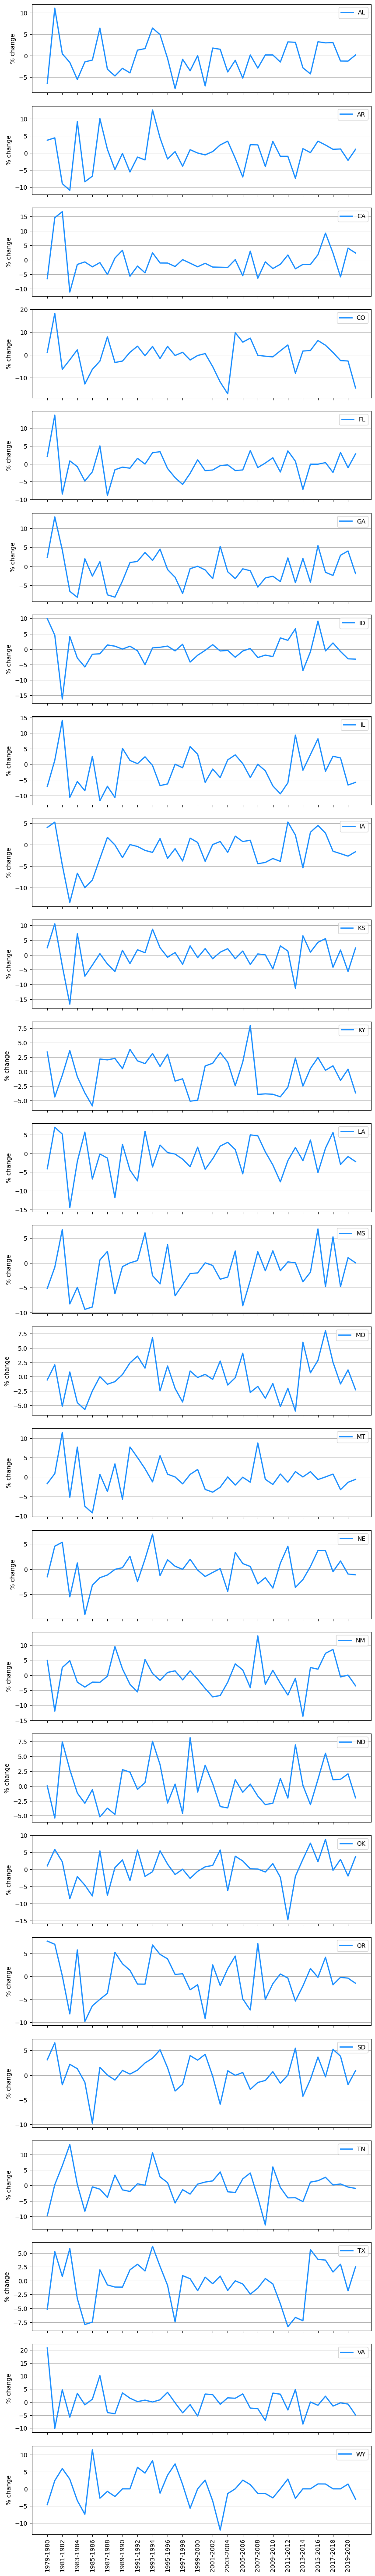

In [61]:
# sharey='col', # sharex=True, sharey=True,
import itertools

num_sub_plots = len(inv_change_state_yr2yr.state.unique())
fig, axs = plt.subplots(num_sub_plots, 1, figsize=(10, 3*num_sub_plots), 
                        sharex=True, gridspec_kw={"hspace": 0.15, "wspace": 0.05})

# state_, full_state_ = "ID", "Idaho"
for count, state_ in enumerate(inv_change_state_yr2yr.state.unique()):
    axs[count].grid(axis="y", which="both")
    B = inv_change_state_yr2yr[inv_change_state_yr2yr.state == state_]
    B.set_index("window", inplace=True)
    B.sort_index(inplace=True)
    axs[count].plot(B.index, B[perc_change_col_].values, c="dodgerblue",
                 linewidth=2, label=state_);

    # add every other ticks
    odd_i = itertools.islice(B.index, 0, None, 2);
    odd_i = list(itertools.chain(odd_i));
    # axs[ii].set_xticks(odd_i, odd_i, rotation ='vertical');
    axs[count].set_ylabel("% change")
    axs[count].legend(loc="best");

plt.tight_layout()
plt.xticks(odd_i, odd_i, rotation ='vertical');

fig_name = plots_dir + 'shannon_annual_inv_change.pdf'
plt.savefig(fname = fig_name, dpi=100, bbox_inches='tight')
# plt.close('all')

In [62]:
shannon_annual.head(2)

,state,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AL,911000.0,852000.0,946000.0,950000.0,935000.0,883000.0,870000.0,861000.0,916000.0,...,680000.0,701000.0,681000.0,652000.0,673000.0,693000.0,714000.0,705000.0,696000.0,697000.0
3,AR,1040000.0,1079000.0,1127000.0,1026000.0,914000.0,998000.0,914000.0,852000.0,938000.0,...,919000.0,851000.0,862000.0,863000.0,893000.0,914000.0,924000.0,935000.0,915000.0,925000.0


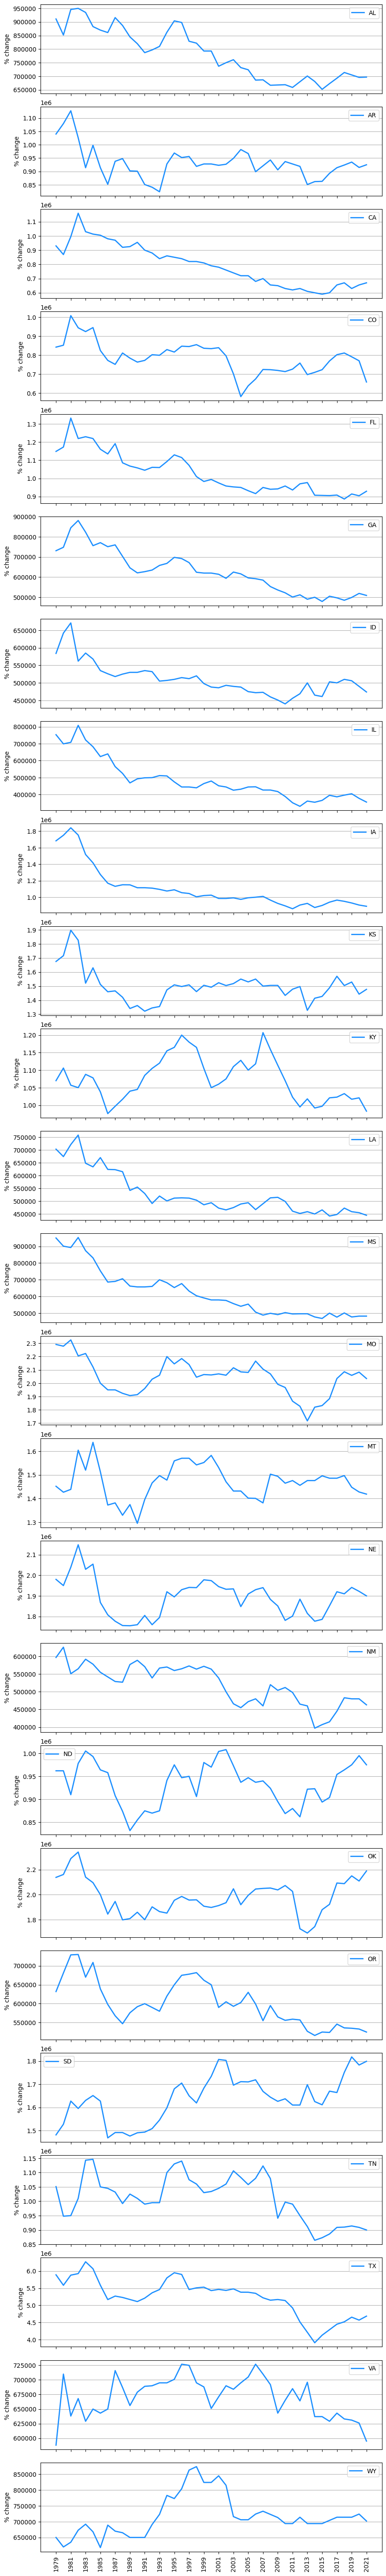

In [63]:
# sharey='col', # sharex=True, sharey=True,
import itertools

num_sub_plots = len(inv_change_state_yr2yr.state.unique())
fig, axs = plt.subplots(num_sub_plots, 1, figsize=(10, 3*num_sub_plots), 
                        sharex=True, gridspec_kw={"hspace": 0.15, "wspace": 0.05})

# state_, full_state_ = "ID", "Idaho"
for count, state_ in enumerate(shannon_annual.state.unique()):
    axs[count].grid(axis="y", which="both")
    B = shannon_annual[shannon_annual.state == state_]
    axs[count].plot(B.columns[1:], B.values[0][1:], c="dodgerblue",
                 linewidth=2, label=state_);

    # add every other ticks
    odd_i = itertools.islice(B.columns[1:], 0, None, 2);
    odd_i = list(itertools.chain(odd_i));
    # axs[ii].set_xticks(odd_i, odd_i, rotation ='vertical');
    axs[count].set_ylabel("% change")
    axs[count].legend(loc="best");

plt.tight_layout()
plt.xticks(odd_i, odd_i, rotation ='vertical');

fig_name = plots_dir + 'shannon_annual_inv.pdf'
plt.savefig(fname = fig_name, dpi=100, bbox_inches='tight')
# plt.close('all')

In [64]:
inv_change_state_yr2yr.head(2)

,state,window,cow_beef_inv_change,cow_beef_inv_change%,full_state
0,AL,1979-1980,-59000.0,-6.48,Alabama
1,AL,1980-1981,94000.0,11.03,Alabama


In [65]:
inv_change_state_yr2yr.window.unique()

array(['1979-1980', '1980-1981', '1981-1982', '1982-1983', '1983-1984',
       '1984-1985', '1985-1986', '1986-1987', '1987-1988', '1988-1989',
       '1989-1990', '1990-1991', '1991-1992', '1992-1993', '1993-1994',
       '1994-1995', '1995-1996', '1996-1997', '1997-1998', '1998-1999',
       '1999-2000', '2000-2001', '2001-2002', '2002-2003', '2003-2004',
       '2004-2005', '2005-2006', '2006-2007', '2007-2008', '2008-2009',
       '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014',
       '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019',
       '2019-2020', '2020-2021'], dtype=object)